In [2]:
import numpy as np
from scipy.fftpack import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
import scipy.sparse as sps
#from scipy.misc import imread 
#N.B. This can be deprecated depending on the python version. Use cv2 in this case
import cv2 # if imread does not work for you.

# N.B. You can install cv2 by calling 'conda install opencv' or 'pip install opencv' in the terminal
# If you have incompatibilities with hdf5, you can uninstall it by command line 'conda remove hdf5' or 
# 'pip remove hdf5' and then install opencv

from scipy.sparse.linalg import LinearOperator, svds
from pywt import wavedec2, waverec2, coeffs_to_array, array_to_coeffs
from collections import namedtuple
from math import sqrt

import time
import pylab as pl
from IPython import display


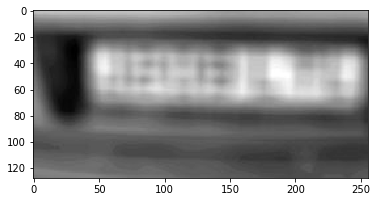

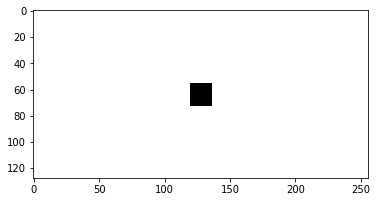

In [41]:
# Mappings between n dimensional complex space and 2n dimensional real space
real2comp = lambda x: x[0:x.shape[0]//2] + 1j*x[x.shape[0]//2:]
comp2real = lambda x: np.append(x.real, x.imag)

# Load Data
# x = imread('blurredplate.jpg',flatten=True,mode='F')
x = cv2.imread('blurredplate.jpg' , cv2.IMREAD_GRAYSCALE) #If imread does not work for you
x = x[60:188,40:296]
x = x/np.linalg.norm(x,ord=np.inf)

imsize1 = x.shape[0]
imsize2 = x.shape[1]
imsize = imsize1*imsize2

# Shows the blurred image!
plt.imshow(x, cmap='gray')
plt.show()

# Reshaping operators matrix to vector and vector to matrix
mat = lambda x: np.reshape(x,[imsize1,imsize2])
vec = lambda x: x.flatten()

# Set the measurement vector b
b = comp2real(vec(fft2(fftshift(x))))

# Roughly estimate the support of the blur kernel
K1 = 17
K2 = 17
Indw = np.zeros([imsize1,imsize2])
ind1 = np.int(imsize1/2-(K1+1)/2+1)
ind2 = np.int(imsize1/2+(K1+1)/2)
ind3 = np.int(imsize2/2-(K2+1)/2+1)
ind4 = np.int(imsize2/2+(K2+1)/2)
Indw[ind1:ind2,ind3:ind4] = 1
# Indw[ind1+17*-1:ind2+17*-1,ind3+17*-0:ind4+17*-0] = 1
# Indw[ind1+17*+1:ind2+17*+1,ind3+17*+0:ind4+17*+0] = 1
#above, for implementational simplicity we assume K1 and K2 odd, even  
#if they are even 1 pixel probably won't cause much trouble
plt.imshow(-Indw, cmap='gray') # Shows the estimated support of blur kernel!
plt.show()
Indw = vec(Indw);
kernelsize = np.count_nonzero(Indw)
Indi = np.nonzero(Indw > 0)[0]
Indv = Indw[Indi]

# Define operators Bop and Cop
Bmat = sps.csr_matrix((Indv,(Indi,range(0,kernelsize))),shape=(imsize,kernelsize))
Bop = lambda x: mat(Bmat.dot(x))
BTop = lambda x: Bmat.T.dot(vec(x))

# Compute and display wavelet coefficients of the original and blurred image
l = coeffs_to_array(wavedec2(x, 'db1', level=4))[1]
Cop = lambda x: waverec2(array_to_coeffs(mat(x),l,output_format='wavedec2'),'db1')
CTop = lambda x: coeffs_to_array(wavedec2(x, 'db1', level=4))[0]

# Define operators
Aoper = lambda m,n,h: comp2real(1.0/sqrt(imsize)*n*vec(fft2(Cop(m))*fft2(Bop(h))))
AToper = {"matvec": lambda y,w: CTop(np.real(fft2(mat(np.conj(real2comp(y))*vec(fft2(Bop(w)))))))/sqrt(y.shape[0]/2.0),
         "rmatvec": lambda y,w: BTop(np.real(ifft2(mat(real2comp(y)*vec(ifft2(Cop(w)))))))*(y.shape[0]/2.0)**1.5}


In [35]:
# def plotFunc(mEst, C, x):
def plotFunc(mEst, C):
    
    xEst = -C(mEst);
    xEst = xEst - min(xEst.flatten())
    xEst = xEst/max(xEst.flatten())
    plt.imshow(xEst, cmap='gray')
    plt.show()


In [42]:
def FrankWolfe(Aoper, AToper, b, n1, n2, kappa, maxit, plotF):
# PURPOSE: We will solve the following problem formulation with
# Frank-Wolfe's method.                                    
#                   min_x  0.5*norm(A(x) - b)^2        
#                   s.t.:  norm_nuc(x) <= kappa,     
#
# Laboratory for Information and Inference Systems (LIONS)
# Ecole Polytechnique Federale de Lausanne (EPFL) - SWITZERLAND
# Last modification: November 26, 2019
    
    # Print the caption
    
    #Initialize 
    AX_t = 0.0   # zeros
    X = 0.0      # zeros
    
    # keep track of objective value
    fx = np.array([])
        
    # The main loop    
    for iteration in range(0, maxit+1):
        
        # Print the objective values ...
        fx = np.append(fx, 0.5*np.linalg.norm(AX_t - b,2)**2)
        print('{:03d} | {:.4e}'.format(iteration, fx[-1]))

        # Form the residual and fix the operator to be used in svds.
        res_cur = AX_t - b
        ATop1 = lambda w: AToper["matvec"](res_cur,w) # ???
        ATop2 = lambda w: AToper["rmatvec"](res_cur,w) # ???
        svdsArg = LinearOperator((n2,n1), matvec=ATop1, rmatvec=ATop2)
        topLe_vec, singVal, topRe_vec = svds(svdsArg, k=1, tol=1e-4, which='LM')
        
        # Apply A to the rank 1 update
        AXsharp_t = Aoper(topLe_vec, -kappa, topRe_vec.T)
        
        # Step size
        weight = 2 / (iteration + 2) #???
        
        # Update A*X
        AX_t = (1.0-weight)*AX_t + weight*(AXsharp_t)
        
        # Update X
        X = (1.0-weight)*X + weight*(-kappa*topLe_vec@topRe_vec)
    
        # Show the reconstruction (at every 10 iteration) 
        if (int(iteration/10) == float(iteration)/10):
            U,S,V = np.linalg.svd(X,full_matrices=0,compute_uv=1)
            plotF(U[:,0])

    return X
    

000 | 4.1535e+03


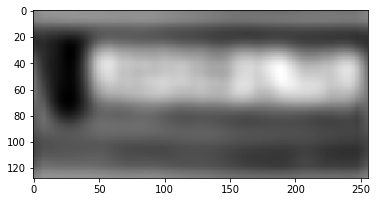

001 | 3.5258e+09
002 | 4.0602e+08
003 | 3.9469e+08
004 | 1.4649e+08
005 | 1.4208e+08
006 | 7.4989e+07
007 | 7.2336e+07
008 | 4.5526e+07
009 | 4.3633e+07
010 | 3.0588e+07


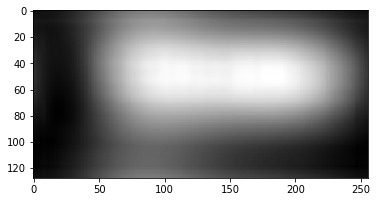

011 | 2.9113e+07
012 | 2.1981e+07
013 | 2.0772e+07
014 | 1.6571e+07
015 | 1.5545e+07
016 | 1.2949e+07
017 | 1.2058e+07
018 | 1.0405e+07
019 | 9.6165e+06
020 | 8.5488e+06


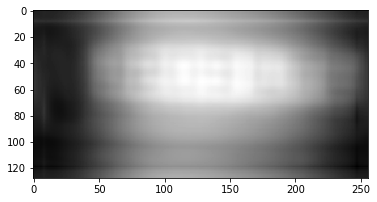

021 | 7.8420e+06
022 | 7.1531e+06
023 | 6.5124e+06
024 | 6.0769e+06
025 | 5.4907e+06
026 | 5.2293e+06
027 | 4.6891e+06
028 | 4.5497e+06
029 | 4.0487e+06
030 | 3.9964e+06


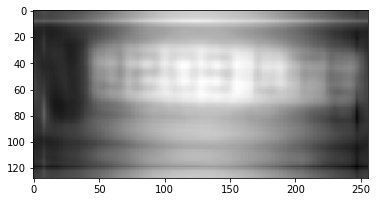

031 | 3.5293e+06
032 | 3.5397e+06
033 | 3.1022e+06
034 | 3.1584e+06
035 | 2.7468e+06
036 | 2.8367e+06
037 | 2.4482e+06
038 | 2.5627e+06
039 | 2.1947e+06
040 | 2.3273e+06


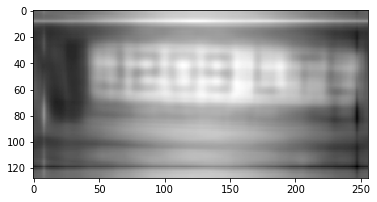

041 | 1.9779e+06
042 | 2.1237e+06
043 | 1.7910e+06
044 | 1.9463e+06
045 | 1.6287e+06
046 | 1.7908e+06
047 | 1.4871e+06
048 | 1.6536e+06
049 | 1.3626e+06
050 | 1.5321e+06


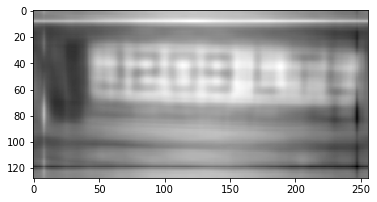

051 | 1.2528e+06
052 | 1.4239e+06
053 | 1.1553e+06
054 | 1.3271e+06
055 | 1.0684e+06
056 | 1.2401e+06
057 | 9.9070e+05
058 | 1.1617e+06
059 | 9.2089e+05
060 | 1.0907e+06


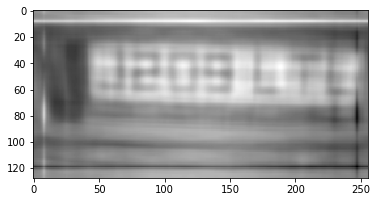

061 | 8.5796e+05
062 | 1.0263e+06
063 | 8.0105e+05
064 | 9.6765e+05
065 | 7.4941e+05
066 | 9.1406e+05
067 | 7.0242e+05
068 | 8.6497e+05
069 | 6.5955e+05
070 | 8.1989e+05


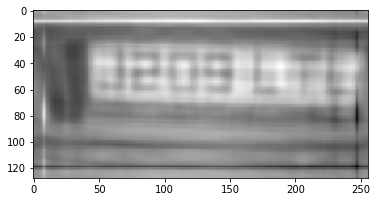

071 | 6.2033e+05
072 | 7.7839e+05
073 | 5.8437e+05
074 | 7.4010e+05
075 | 5.5131e+05
076 | 7.0469e+05
077 | 5.2086e+05
078 | 6.7187e+05
079 | 4.9275e+05
080 | 6.4140e+05


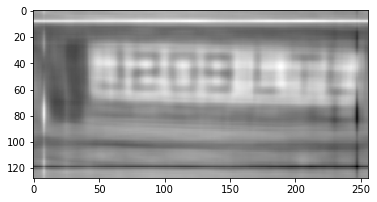

081 | 4.6675e+05
082 | 6.1306e+05
083 | 4.4266e+05
084 | 5.8665e+05
085 | 4.2029e+05
086 | 5.6199e+05
087 | 3.9950e+05
088 | 5.3894e+05
089 | 3.8013e+05
090 | 5.1735e+05


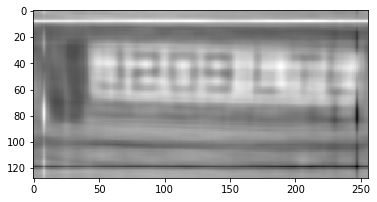

091 | 3.6206e+05
092 | 4.9710e+05
093 | 3.4518e+05
094 | 4.7809e+05
095 | 3.2939e+05
096 | 4.6021e+05
097 | 3.1460e+05
098 | 4.4337e+05
099 | 3.0072e+05
100 | 4.2749e+05


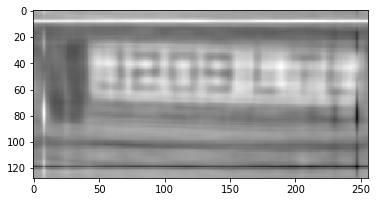

101 | 2.8769e+05
102 | 4.1250e+05
103 | 2.7544e+05
104 | 3.9834e+05
105 | 2.6390e+05
106 | 3.8494e+05
107 | 2.5303e+05
108 | 3.7224e+05
109 | 2.4278e+05
110 | 3.6021e+05


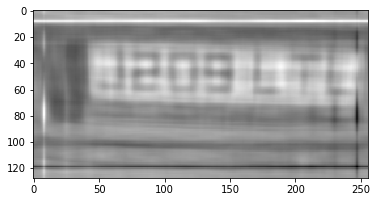

111 | 2.3309e+05
112 | 3.4879e+05
113 | 2.2394e+05
114 | 3.3794e+05
115 | 2.1527e+05
116 | 3.2763e+05
117 | 2.0707e+05
118 | 3.1781e+05
119 | 1.9929e+05
120 | 3.0846e+05


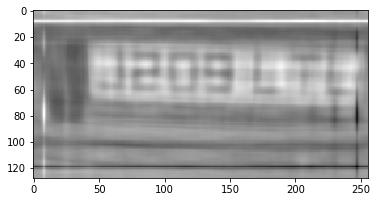

121 | 1.9191e+05
122 | 2.9955e+05
123 | 1.8490e+05
124 | 2.9105e+05
125 | 1.7825e+05
126 | 2.8293e+05
127 | 1.7191e+05
128 | 2.7517e+05
129 | 1.6589e+05
130 | 2.6776e+05


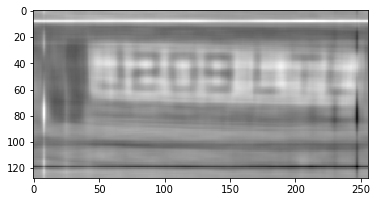

131 | 1.6015e+05
132 | 2.6066e+05
133 | 1.5468e+05
134 | 2.5386e+05
135 | 1.4946e+05
136 | 2.4735e+05
137 | 1.4448e+05
138 | 2.4111e+05
139 | 1.3972e+05
140 | 2.3512e+05


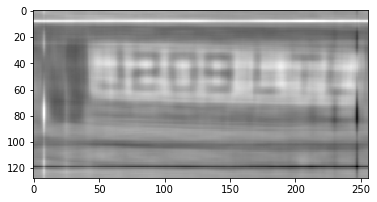

141 | 1.3518e+05
142 | 2.2937e+05
143 | 1.3083e+05
144 | 2.2385e+05
145 | 1.2667e+05
146 | 2.1854e+05
147 | 1.2269e+05
148 | 2.1343e+05
149 | 1.1888e+05
150 | 2.0852e+05


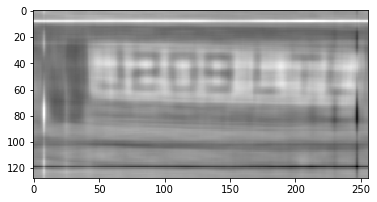

151 | 1.1523e+05
152 | 2.0380e+05
153 | 1.1173e+05
154 | 1.9924e+05
155 | 1.0836e+05
156 | 1.9485e+05
157 | 1.0514e+05
158 | 1.9062e+05
159 | 1.0204e+05
160 | 1.8654e+05


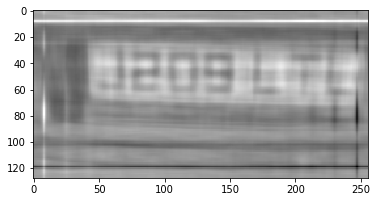

161 | 9.9065e+04
162 | 1.8260e+05
163 | 9.6204e+04
164 | 1.7880e+05
165 | 9.3453e+04
166 | 1.7513e+05
167 | 9.0806e+04
168 | 1.7158e+05
169 | 8.8259e+04
170 | 1.6815e+05


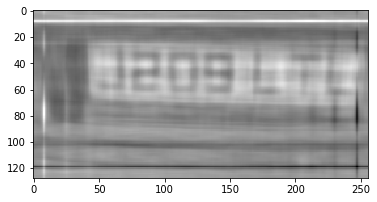

171 | 8.5806e+04
172 | 1.6483e+05
173 | 8.3443e+04
174 | 1.6162e+05
175 | 8.1167e+04
176 | 1.5852e+05
177 | 7.8972e+04
178 | 1.5551e+05
179 | 7.6855e+04
180 | 1.5259e+05


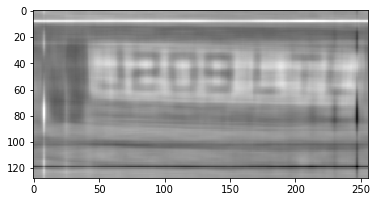

181 | 7.4813e+04
182 | 1.4977e+05
183 | 7.2842e+04
184 | 1.4703e+05
185 | 7.0939e+04
186 | 1.4438e+05
187 | 6.9101e+04
188 | 1.4180e+05
189 | 6.7325e+04
190 | 1.3931e+05


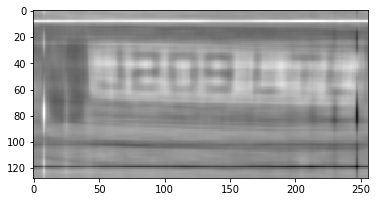

191 | 6.5609e+04
192 | 1.3688e+05
193 | 6.3950e+04
194 | 1.3453e+05
195 | 6.2346e+04
196 | 1.3224e+05
197 | 6.0794e+04
198 | 1.3002e+05
199 | 5.9292e+04
200 | 1.2786e+05


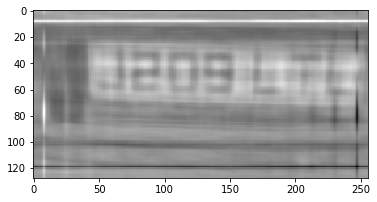

In [43]:
# Run Frank-Wolfe's method
MaxIters = 200
kappa = 5000
plotF = lambda m: plotFunc(m,Cop)
xFW = FrankWolfe(Aoper, AToper, b, kernelsize, imsize, kappa, MaxIters, plotF)

In [ ]:
# NOTE: This experiment is based on the theory and the codes publised in
#'Blind Deconvolution using Convex Programming' by A.Ahmed, B.Recht and J.Romberg.